In [243]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D

from filter_data_helpers import get_halos_based_on_filters, get_profiles
plt.rcParams.update({'font.size': 18})
plt.rc('legend',fontsize=14)
import pandas as pd
import xray_emissivity
import math

HUBBLE = 0.6711
Msun = 1.99e33
kpc = 3.0856e21
Mpc = 1e3*kpc
kb = 1.38e-16
mu = 0.59
X_H = 0.76
mp = 1.67e-24

mue = 2/(1+X_H)

erg2keV = 6.242e8 #convert from erg to keV
cgs_density = Msun * kpc**(-3) # from Msun kpc^-3 to g cm^-3
# from Msol (km/s)**2 to keV cm^-3 
pressure_conversion_factor = 1 / kpc * erg2keV
Zsun = 0.0127 
temperature_conversion_factor = (1e5)**2 * kb * erg2keV

rad2arcmin = 180.0/math.pi * 60.0
ster2sqdeg = 3282.80635
ster2sqarcmin = ster2sqdeg * 3600.0
ster2sqarcsec = ster2sqdeg * 3600.0 * 3600.0

In [221]:
xray = xray_emissivity.XrayEmissivity()
xray.read_emissivity_table('etable_05_2keV_cnts.hdf5')
eff_area = 2000.0 #cm^2


In [228]:
def abel_projection(rad, prof3D) :

    prof2D = np.zeros(prof3D.shape)
    proj_rad = rad
        
    dr = np.zeros(rad.shape)
    for ir, r in enumerate(proj_rad) :
        if ir > 0:
            dr[ir] = rad[ir] - rad[ir-1]

    for irp, rp in enumerate(proj_rad) :
        integ = 0.0
        for ir, r in enumerate(rad) :
            if r > rp :
                integ += prof3D[ir,:]*2*r*dr[ir]/np.sqrt(r**2-rp**2)

        prof2D[irp,:] = integ

    return prof2D

def return_halo_ids_bins(sim, mass_ranges= [(10, 100), (100, 1000)]) :

    # Select halos based on mass cut and simulation ID
    halo_ids_result = get_halos_based_on_filters(
        list_of_inequality_filters=[("M_Crit200", 1/HUBBLE, 1e5/HUBBLE)],
        list_of_equality_filters=[("simulation_unique_id", [sim])]
    )
    
    halo_IDs = halo_ids_result["ID"]
    simulation_IDs = halo_ids_result["simulation_unique_id"]
    
    label_mass_ranges = [(1e10*low/HUBBLE, 1e10*high/HUBBLE) for (low, high) in mass_ranges]
    halo_IDs_bins = [list(halo_ids_result[(halo_ids_result["M_Crit200"] >= low) 
                                        & (halo_ids_result["M_Crit200"] < high)]["ID"])
                     for (low, high) in mass_ranges]
    
    return halo_IDs_bins, label_mass_ranges
    
def return_profiles(sim) :

    # Select halos based on mass cut and simulation ID
    halo_ids_result = get_halos_based_on_filters(
        list_of_inequality_filters=[("M_Crit200", 1/HUBBLE, 1e5/HUBBLE)],
        list_of_equality_filters=[("simulation_unique_id", [sim])]
    )

    halo_IDs = halo_ids_result["ID"]
    simulation_IDs = halo_ids_result["simulation_unique_id"]
    
    # Select profiles for the filtered halo IDs
    density_profiles = get_profiles(
        list_of_halo_ids=halo_IDs,
        list_of_snapshots=[33],
        list_of_simulation_ids=simulation_IDs,
        list_of_properties=["gas_density"]
    )

    pressure_profiles = get_profiles(
        list_of_halo_ids=halo_IDs,
        list_of_snapshots=[33],
        list_of_simulation_ids=simulation_IDs,
        list_of_properties=["gas_pressure"]
    )

    temperature_profiles = get_profiles(
        list_of_halo_ids=halo_IDs,
        list_of_snapshots=[33],
        list_of_simulation_ids=simulation_IDs,
        list_of_properties=["temperature"]
    )

    metallicity_profiles = get_profiles(
        list_of_halo_ids=halo_IDs,
        list_of_snapshots=[33],
        list_of_simulation_ids=simulation_IDs,
        list_of_properties=["metallicity"]
    )

    # Rescale data to common units
    density_profiles["radius"] *= 1 / (HUBBLE) # Convert to kpc
    pressure_profiles["radius"] *= 1 / (HUBBLE) # Convert to kpc
    temperature_profiles["radius"] *= 1 / (HUBBLE) # Convert to kpc
    metallicity_profiles["radius"] *= 1 / (HUBBLE) # Convert to kpc

    density_profiles["property_value"] *= 1e10 * HUBBLE * HUBBLE \
                                      * cgs_density  # Convert from Msun * kpc^-3 to g cm^-3
    pressure_profiles["property_value"] *= 1e10 * HUBBLE  \
                                      * pressure_conversion_factor # 1e10Msol/h*(km/s)**2 convert to keV cm^-3
    temperature_profiles["property_value"] *= temperature_conversion_factor
    metallicity_profiles["property_value"] /= Zsun
    
    profiles = {}
    profiles['radius'] = density_profiles["radius"]
    profiles['density'] = density_profiles.pivot(index="radius", columns="ID", values="property_value")
    profiles['pressure'] = pressure_profiles.pivot(index="radius", columns="ID", values="property_value")
    profiles['temperature'] = temperature_profiles.pivot(index="radius", columns="ID", values="property_value")
    profiles['metallicity'] = metallicity_profiles.pivot(index="radius", columns="ID", values="property_value")

    np_xray_emissivity = xray.return_interpolated_emissivity(profiles['temperature'].to_numpy(), profiles['metallicity'].to_numpy()) 

    #number densities of electron and H
    nH = profiles['density'].to_numpy() * X_H / mp
    ne = profiles['density'].to_numpy() / (mue * mp)

    np_xray_emissivity *= ne * nH * eff_area
    
    np_rad = profiles['density'].index.to_numpy() #in kpc
         
    xray_redshift = 0.01
    DA = cosmo.angularDiameterDistance(xray_redshift)*1000/(cosmo.H0/100.0) # in kpc
   
    # Project X-ray emmissivity to get X-ray surface brightness
    np_xsb = abel_projection(np_rad*kpc , np_xray_emissivity ) / (4.0*math.pi) 
    # account for redshift dimming, change units from per steradians to per arcmin^2
    np_xsb *= 1.0 /(1+xray_redshift)**4.0 /ster2sqarcmin 

    # convert numpy profiles to dataframes
    profiles['xray_emissivity'] = pd.DataFrame(np_xray_emissivity, 
                                       index = (profiles['temperature']).index, 
                                       columns = (profiles['temperature']).columns )
    profiles['xray_surface_brightness'] = pd.DataFrame(np_xsb, 
                                       index = (profiles['temperature']).index, 
                                       columns = (profiles['temperature']).columns )

    #convert mass density to number density
    profiles['density'] = profiles['density'] / mu /mp
    
    # Filter radial values
    for k in profiles.keys() :
        profiles[k]= profiles[k][(profiles[k].index > 8) & (profiles[k].index < 300)]

    return profiles

In [233]:
profiles_labels = {}
profiles_labels['density'] = r"$n_{\rm gas}\,[{\rm cm^{-3}}]$"
profiles_labels['pressure'] = r"$P_{\rm gas}\,[{\rm keV\, cm^{-3}}]$"
profiles_labels['temperature'] = r"$T_{\rm gas}\,[{\rm keV}]$"
profiles_labels['metallicity'] = r"$Z_{\rm gas}\,[Z_\odot]$"
profiles_labels['xray_emissivity'] = r"$\epsilon_{X}\,[{\rm cts\,cm^{-1}s^{-1}}]$"
profiles_labels['xray_surface_brightness'] = r"$S_{X}\,[{\rm cts\, s^{-1}\, arcmin^{-2}}]$"

In [234]:
simulations = ["IllustrisTNG_1P_22","IllustrisTNG_1P_23","IllustrisTNG_LH_0","IllustrisTNG_LH_1", "SIMBA_1P_22" ]
#simulations = ["IllustrisTNG_1P_22","IllustrisTNG_1P_23","SIMBA_1P_22" ]

simulations_labels = {"IllustrisTNG_1P_22":r"TNG 1P22","IllustrisTNG_1P_23":r"TNG 1P23",
                      "IllustrisTNG_LH_0":r"TNG LH0","IllustrisTNG_LH_1":r"TNG LH1", "SIMBA_1P_22":r"SIMBA 1P22" }

In [235]:
profiles = {}
halo_IDs_bins = {}
label_mass_ranges = {}
mass_ranges= [(100, 1000)]

for sim in simulations :
    halo_IDs_bins[sim], label_mass_ranges[sim] = return_halo_ids_bins(sim, mass_ranges=mass_ranges)
    profiles[sim] = return_profiles(sim)

/Users/ethlau/Research/CAMELS/camels-database-schemas/xray_emissivity.py:353: RuntimeWarning: divide by zero encountered in log10
  lt = np.log10(temperature)
/Users/ethlau/Research/CAMELS/camels-database-schemas/xray_emissivity.py:354: RuntimeWarning: divide by zero encountered in log10
  lz = np.log10(metallicity)
/Users/ethlau/Research/CAMELS/camels-database-schemas/xray_emissivity.py:353: RuntimeWarning: divide by zero encountered in log10
  lt = np.log10(temperature)
/Users/ethlau/Research/CAMELS/camels-database-schemas/xray_emissivity.py:354: RuntimeWarning: divide by zero encountered in log10
  lz = np.log10(metallicity)
/Users/ethlau/Research/CAMELS/camels-database-schemas/xray_emissivity.py:353: RuntimeWarning: divide by zero encountered in log10
  lt = np.log10(temperature)
/Users/ethlau/Research/CAMELS/camels-database-schemas/xray_emissivity.py:354: RuntimeWarning: divide by zero encountered in log10
  lz = np.log10(metallicity)
/Users/ethlau/Research/CAMELS/camels-database-

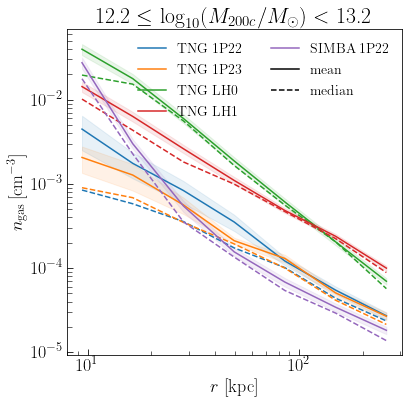

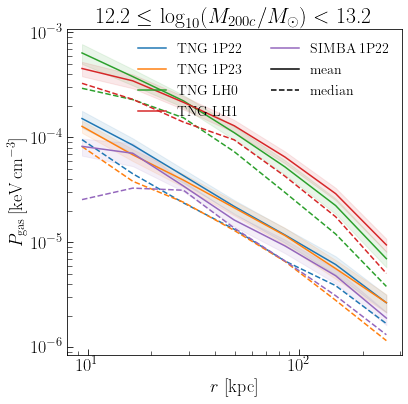

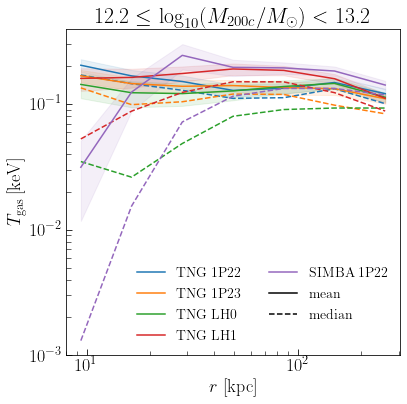

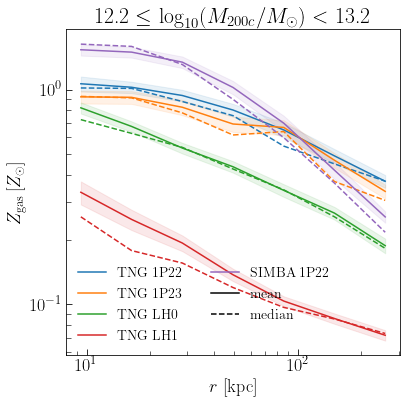

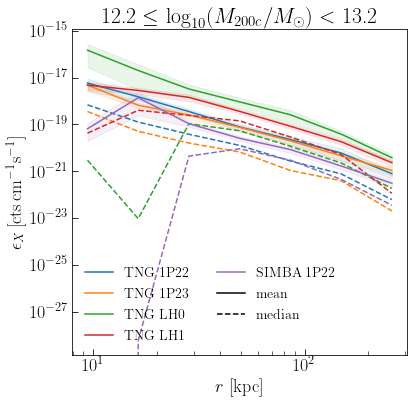

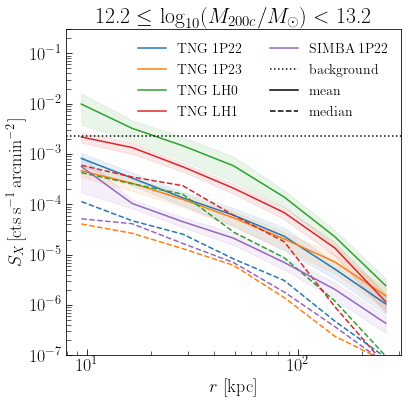

In [247]:
for k in profiles_labels.keys() :
    fig, ax = plt.subplots(1, 1, figsize=(6, 6))

    color_list = ["C0", "C1", "C2", "C3", "C4", "C5"]
    
    for isim, sim in enumerate(simulations):

        for mass_range, halo_IDs_bin in zip(label_mass_ranges[sim], halo_IDs_bins[sim]):
            low, high = np.log10(mass_range)

            binned_profiles = profiles[sim][k][halo_IDs_bin]

            profiles_16 = binned_profiles.quantile(q=0.16, axis="columns")
            profiles_84 = binned_profiles.quantile(q=0.84, axis="columns")
            profiles_05 = binned_profiles.quantile(q=0.05, axis="columns")
            profiles_95 = binned_profiles.quantile(q=0.95, axis="columns")
            profiles_median = binned_profiles.quantile(q=0.5, axis="columns")
            
            profiles_sigma = binned_profiles.std(axis="columns")/np.sqrt(binned_profiles.count(axis="columns"))
            profiles_mean = binned_profiles.mean(axis="columns")

            label_str = r'\textrm{'+simulations_labels[sim]+'}'
            
            plt.plot(profiles_median.index, profiles_median, ls='--', color=color_list[isim])
            #ax.fill_between(profiles_16.index, profiles_05, profiles_84, alpha=0.1, color=color_list[isim])

            plt.plot(profiles_mean.index, profiles_mean,label=label_str , color=color_list[isim])
            ax.fill_between(profiles_mean.index,profiles_mean-profiles_sigma, profiles_mean+profiles_sigma, alpha=0.1, color=color_list[isim])

            #for ih in halo_IDs_bin :
            #    plt.plot(profiles[sim][k][ih].index, profiles[sim][k][ih], alpha=0.1, color=color_list[isim])
                

    title_str =f"{low:.1f} $\leq$" + r" $\log_{10} (M_{200c} / M_{\odot}) <$" + f" {high:.1f}"
    ax.set_title (title_str)
    ax.legend(frameon=False)
    
    if k == 'xray_surface_brightness':
        xbgd = 2.3e-3
        ax.axhline (xbgd, color='k', ls=':', label='background')
        ax.set_ylim(1e-7, 3e-1)

    handles, labels = ax.get_legend_handles_labels()
    h = [ Line2D((0,1),(0,0), color='k',ls='-', alpha=1.0),
              Line2D((0,1),(0,0), color='k',ls='--', alpha=1.0)]

    l = ['mean', 'median']
    ax.legend(handles+h, labels+l, ncol=2, loc='best',frameon=False)        
            
    # Display plot
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlabel(r"$r$ [kpc]")
    ax.set_ylabel(profiles_labels[k])

    plt.show()    